## Evaluation of the best models

In [1]:
import torch
import torchmetrics
import sys
import os
import lightning as L
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

if project_root not in sys.path:
    sys.path.append(project_root)
    
    
from model_config import NUM_CLASSES
from model_utils import ClassificationData, ModelTransformer
from densenet_utils import DenseNetLit

torch.cuda.empty_cache()
torch.set_float32_matmul_precision("medium")
L.seed_everything(111)

Seed set to 111


111

In [2]:
densenet_hyperparameters = {
    "depth": 40,
    "first_output": 16,
    "growth_rate": 12,
    "dropout": 0.2,
}
transformer_hyperparameters = {
    "learning_rate": 1e-4,
    "weight_decay": 1e-5,
    "batch_size": 512,
}
weights = torch.tensor([0.0794, 0.0766, 0.0687, 0.0687, 0.0660, 0.0660, 0.0685, 0.2992, 0.0666, 0.0038, 0.0678, 0.0688])
transformer_hyperparameters = {"learning_rate": 0, "weight_decay": 0, "batch_size": 512}

In [3]:
data = ClassificationData()
dense_net = DenseNetLit.load_from_checkpoint("../experimental/checkpoints/densenet/full-epoch=132-val_f1_macro=0.928-val_accuracy=0.957.ckpt", hyperparameters=densenet_hyperparameters)
# transformer = ModelTransformer.load_from_checkpoint("./checkpoints/transformer/epoch=36-val_f1_macro=0.872-val_accuracy=0.928.ckpt", hyperparameters=transformer_hyperparameters)
# transformer_weight_loss = ModelTransformer.load_from_checkpoint("./checkpoints/transformer/epoch=43-val_f1_macro=0.822-val_accuracy=0.880.ckpt", hyperparameters=transformer_hyperparameters, weight=weights)
# transformer_undersampling = ModelTransformer.load_from_checkpoint("./checkpoints/transformer/undersampling-epoch=47-val_f1_macro=0.592-val_accuracy=0.622.ckpt", hyperparameters=transformer_hyperparameters)
transformer_augmentation = ModelTransformer.load_from_checkpoint("./checkpoints/transformer/augmentation-epoch=67-val_f1_macro=0.880-val_accuracy=0.933.ckpt", hyperparameters=transformer_hyperparameters)
data.setup("test")
test_loader = data.test_dataloader()

In [4]:
def evaluate(loaded_model, test_loader):
    loaded_model.eval()
    with torch.no_grad():
        probabilities = []
        for batch in test_loader:
            x, y = batch
            x = x.to(loaded_model.device)
            y = y.to(loaded_model.device)
            logits = loaded_model(x)
            probabilities_append = torch.softmax(logits, dim=1)
            probabilities.append(probabilities_append)
        probabilities = torch.cat(probabilities).to(loaded_model.device)
        y = torch.cat([batch[1] for batch in test_loader]).to(loaded_model.device)
        f1 = torchmetrics.F1Score(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(loaded_model.device)
        recall = torchmetrics.Recall(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(loaded_model.device)
        precision = torchmetrics.Precision(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(loaded_model.device)
        precision_no_avg = torchmetrics.Precision(task="multiclass", num_classes=NUM_CLASSES, average=None).to(loaded_model.device)
        recall_no_avg = torchmetrics.Recall(task="multiclass", num_classes=NUM_CLASSES, average=None).to(loaded_model.device)
        f1_no_avg = torchmetrics.F1Score(task="multiclass", num_classes=NUM_CLASSES, average=None).to(loaded_model.device)
        acc = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(loaded_model.device)
        precision_recall_curve = torchmetrics.PrecisionRecallCurve(task="multiclass", num_classes=NUM_CLASSES).to(loaded_model.device)
        confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=NUM_CLASSES, task="multiclass").to(loaded_model.device)
        per_class_precision = precision_no_avg(probabilities, y)
        per_class_recall = recall_no_avg(probabilities, y)
        per_class_f1 = f1_no_avg(probabilities, y)
        precision_recall_curve.update(probabilities, y)
        f1_macro = f1(probabilities, y)
        recall_macro = recall(probabilities, y)
        accuracy = acc(probabilities, y)
        precision_macro = precision(probabilities, y)
        confusion_matrix.update(probabilities, y)
        return {
            "f1_macro": f1_macro,
            "recall_macro": recall_macro,
            "precision_macro": precision_macro,
            "f1_no_avg": f1_no_avg,
            "recall_no_avg": recall_no_avg,
            "precision_no_avg": precision_no_avg,
            "per_class_precision": per_class_precision,
            "per_class_recall": per_class_recall,
            "per_class_f1": per_class_f1,
            "precision_recall_curve": precision_recall_curve,
            "confusion_matrix": confusion_matrix,
            "accuracy": accuracy,
        }

dense_net_metrics = evaluate(dense_net, test_loader)
# transformer_metrics = evaluate(transformer, test_loader)
# transformer_weight_loss_metrics = evaluate(transformer_weight_loss, test_loader)
# transformer_undersampling_metrics = evaluate(transformer_undersampling, test_loader)
transformer_augmentation_metrics = evaluate(transformer_augmentation, test_loader)

def show_evaluation(metrics, model_name):
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['accuracy'].item()}")
    print(f"Macro Average Precision: {metrics['precision_macro'].item()}")
    print(f"Macro Average Recall: {metrics['recall_macro'].item()}")
    print(f"Macro Average F1: {metrics['f1_macro'].item()}")
    print(f"No Average Precision: {metrics['precision_no_avg']}")
    print(f"No Average Recall: {metrics['recall_no_avg']}")
    print(f"No Average F1: {metrics['f1_no_avg']}")
    plt.figure(figsize=(16, 10))
    LABELS = os.listdir("../data-no-noise-no-silence/train")
    data = {
        "Class": LABELS,
        "Recall": metrics["per_class_recall"].cpu().numpy(),
        "Precision": metrics["per_class_precision"].cpu().numpy(),
        "F1": metrics["per_class_f1"].cpu().numpy(),
    }
    df = pd.DataFrame(data)

    df_long = df.melt(id_vars="Class", value_vars=["Recall", "Precision", "F1"],
                    var_name="Metric", value_name="Score")

    sns.barplot(x="Score", y="Class", hue="Metric", data=df_long, orient="h")
    plt.title(f"Per-class Precision, Recall and F1 for model: {model_name}", fontsize=24)
    plt.xlabel("Score", fontsize=20)
    plt.ylabel("Class", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.figure.set_size_inches(18, 10)
    ax.set_title(f"Precision-Recall Curve for model {model_name}", fontsize=24)
    metrics["precision_recall_curve"].plot(ax=ax)
    for i, line in enumerate(ax.lines):
        line.set_color(plt.cm.tab20(i))
    ax.legend(LABELS, loc="lower left")
    plt.show()
    
    confusion_matrix = metrics["confusion_matrix"].compute().cpu()
    confusion_matrix_df = pd.DataFrame(confusion_matrix.numpy(), index=LABELS, columns=LABELS)
    plt.figure(figsize=(16*2.5, 11*2.5))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="viridis", xticklabels=LABELS, yticklabels=LABELS, cbar=False, annot_kws={"size": 20})
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title(f"Confusion Matrix for model {model_name}", fontsize=24)
    plt.show()
    print("Most common mistakes:")
    most_common_mistakes = []
    for i in range(NUM_CLASSES):
        for j in range(NUM_CLASSES):
            if i != j:
                most_common_mistakes.append((f"{LABELS[i]} -> {LABELS[j]}: {confusion_matrix_df.iloc[i, j]}", confusion_matrix_df.iloc[i, j]))
                
    most_common_mistakes.sort(key=lambda x: x[1], reverse=True)
    print(most_common_mistakes[:5])

Model: DenseNet
Accuracy: 0.9480839371681213
Macro Average Precision: 0.9256800413131714
Macro Average Recall: 0.9022449254989624
Macro Average F1: 0.9132518768310547
No Average Precision: MulticlassPrecision()
No Average Recall: MulticlassRecall()
No Average F1: MulticlassF1Score()


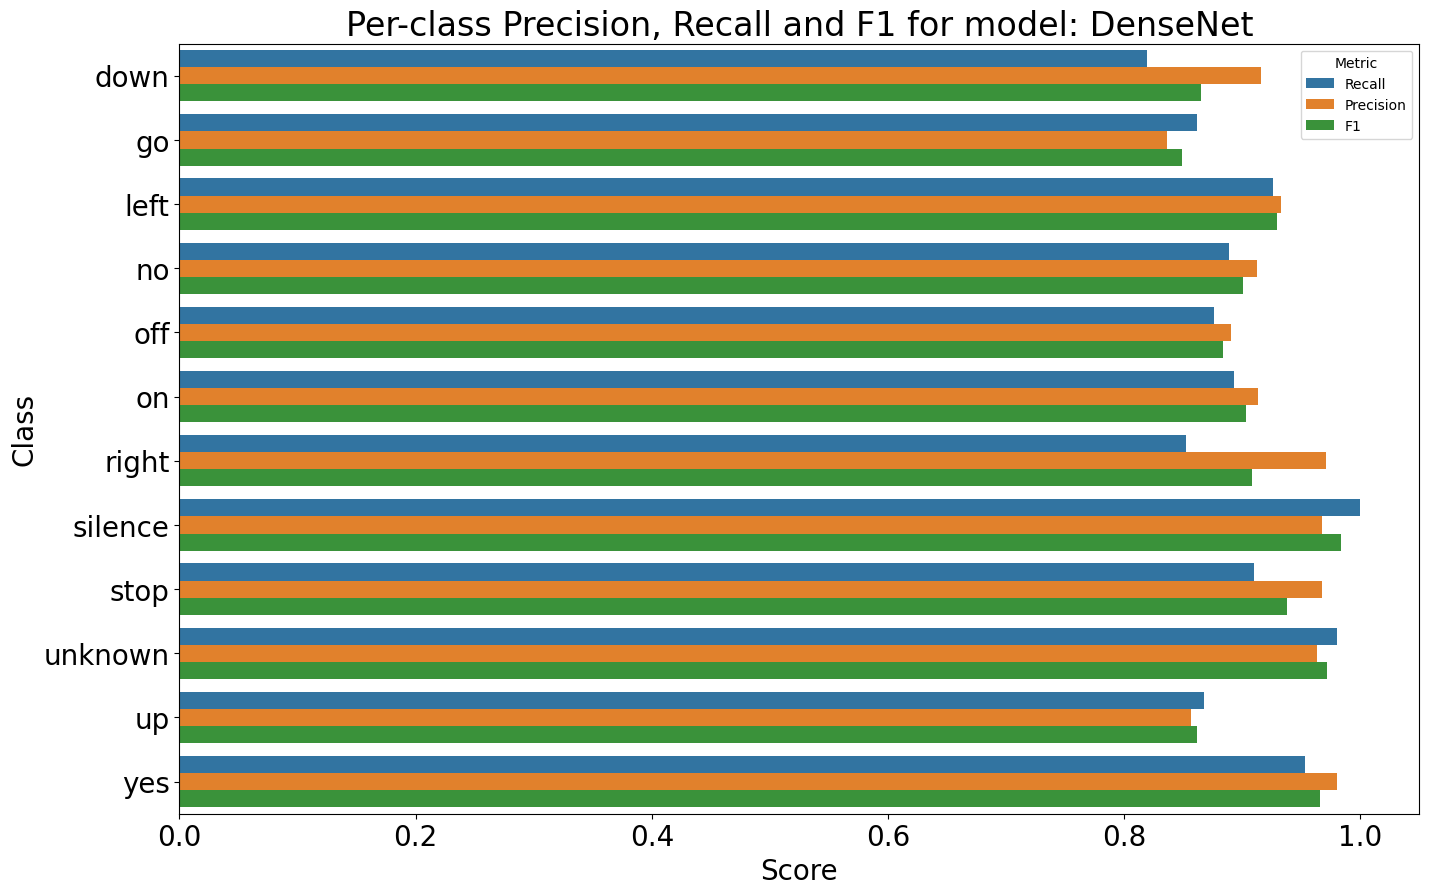

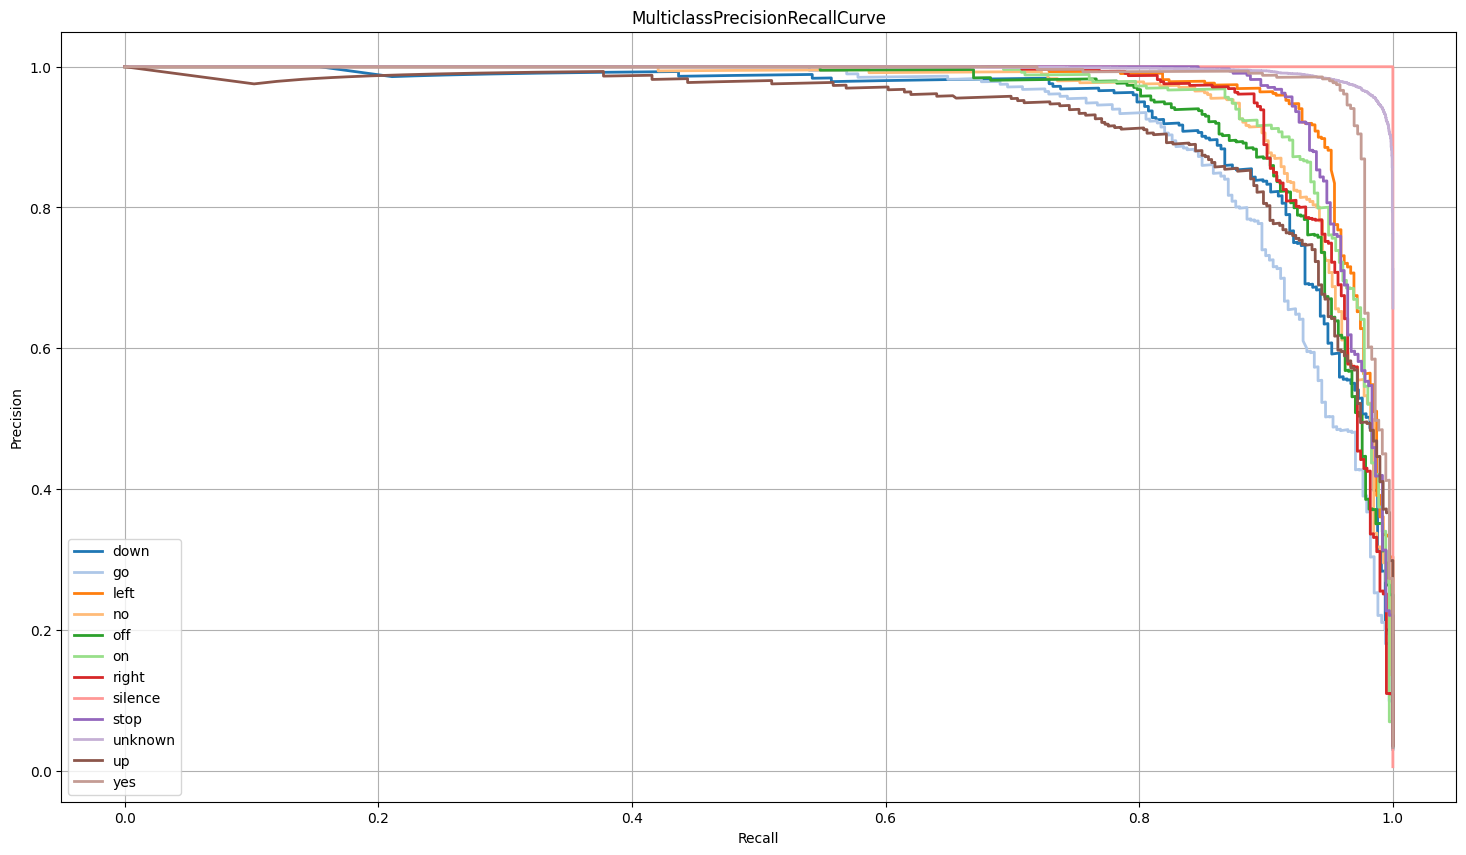

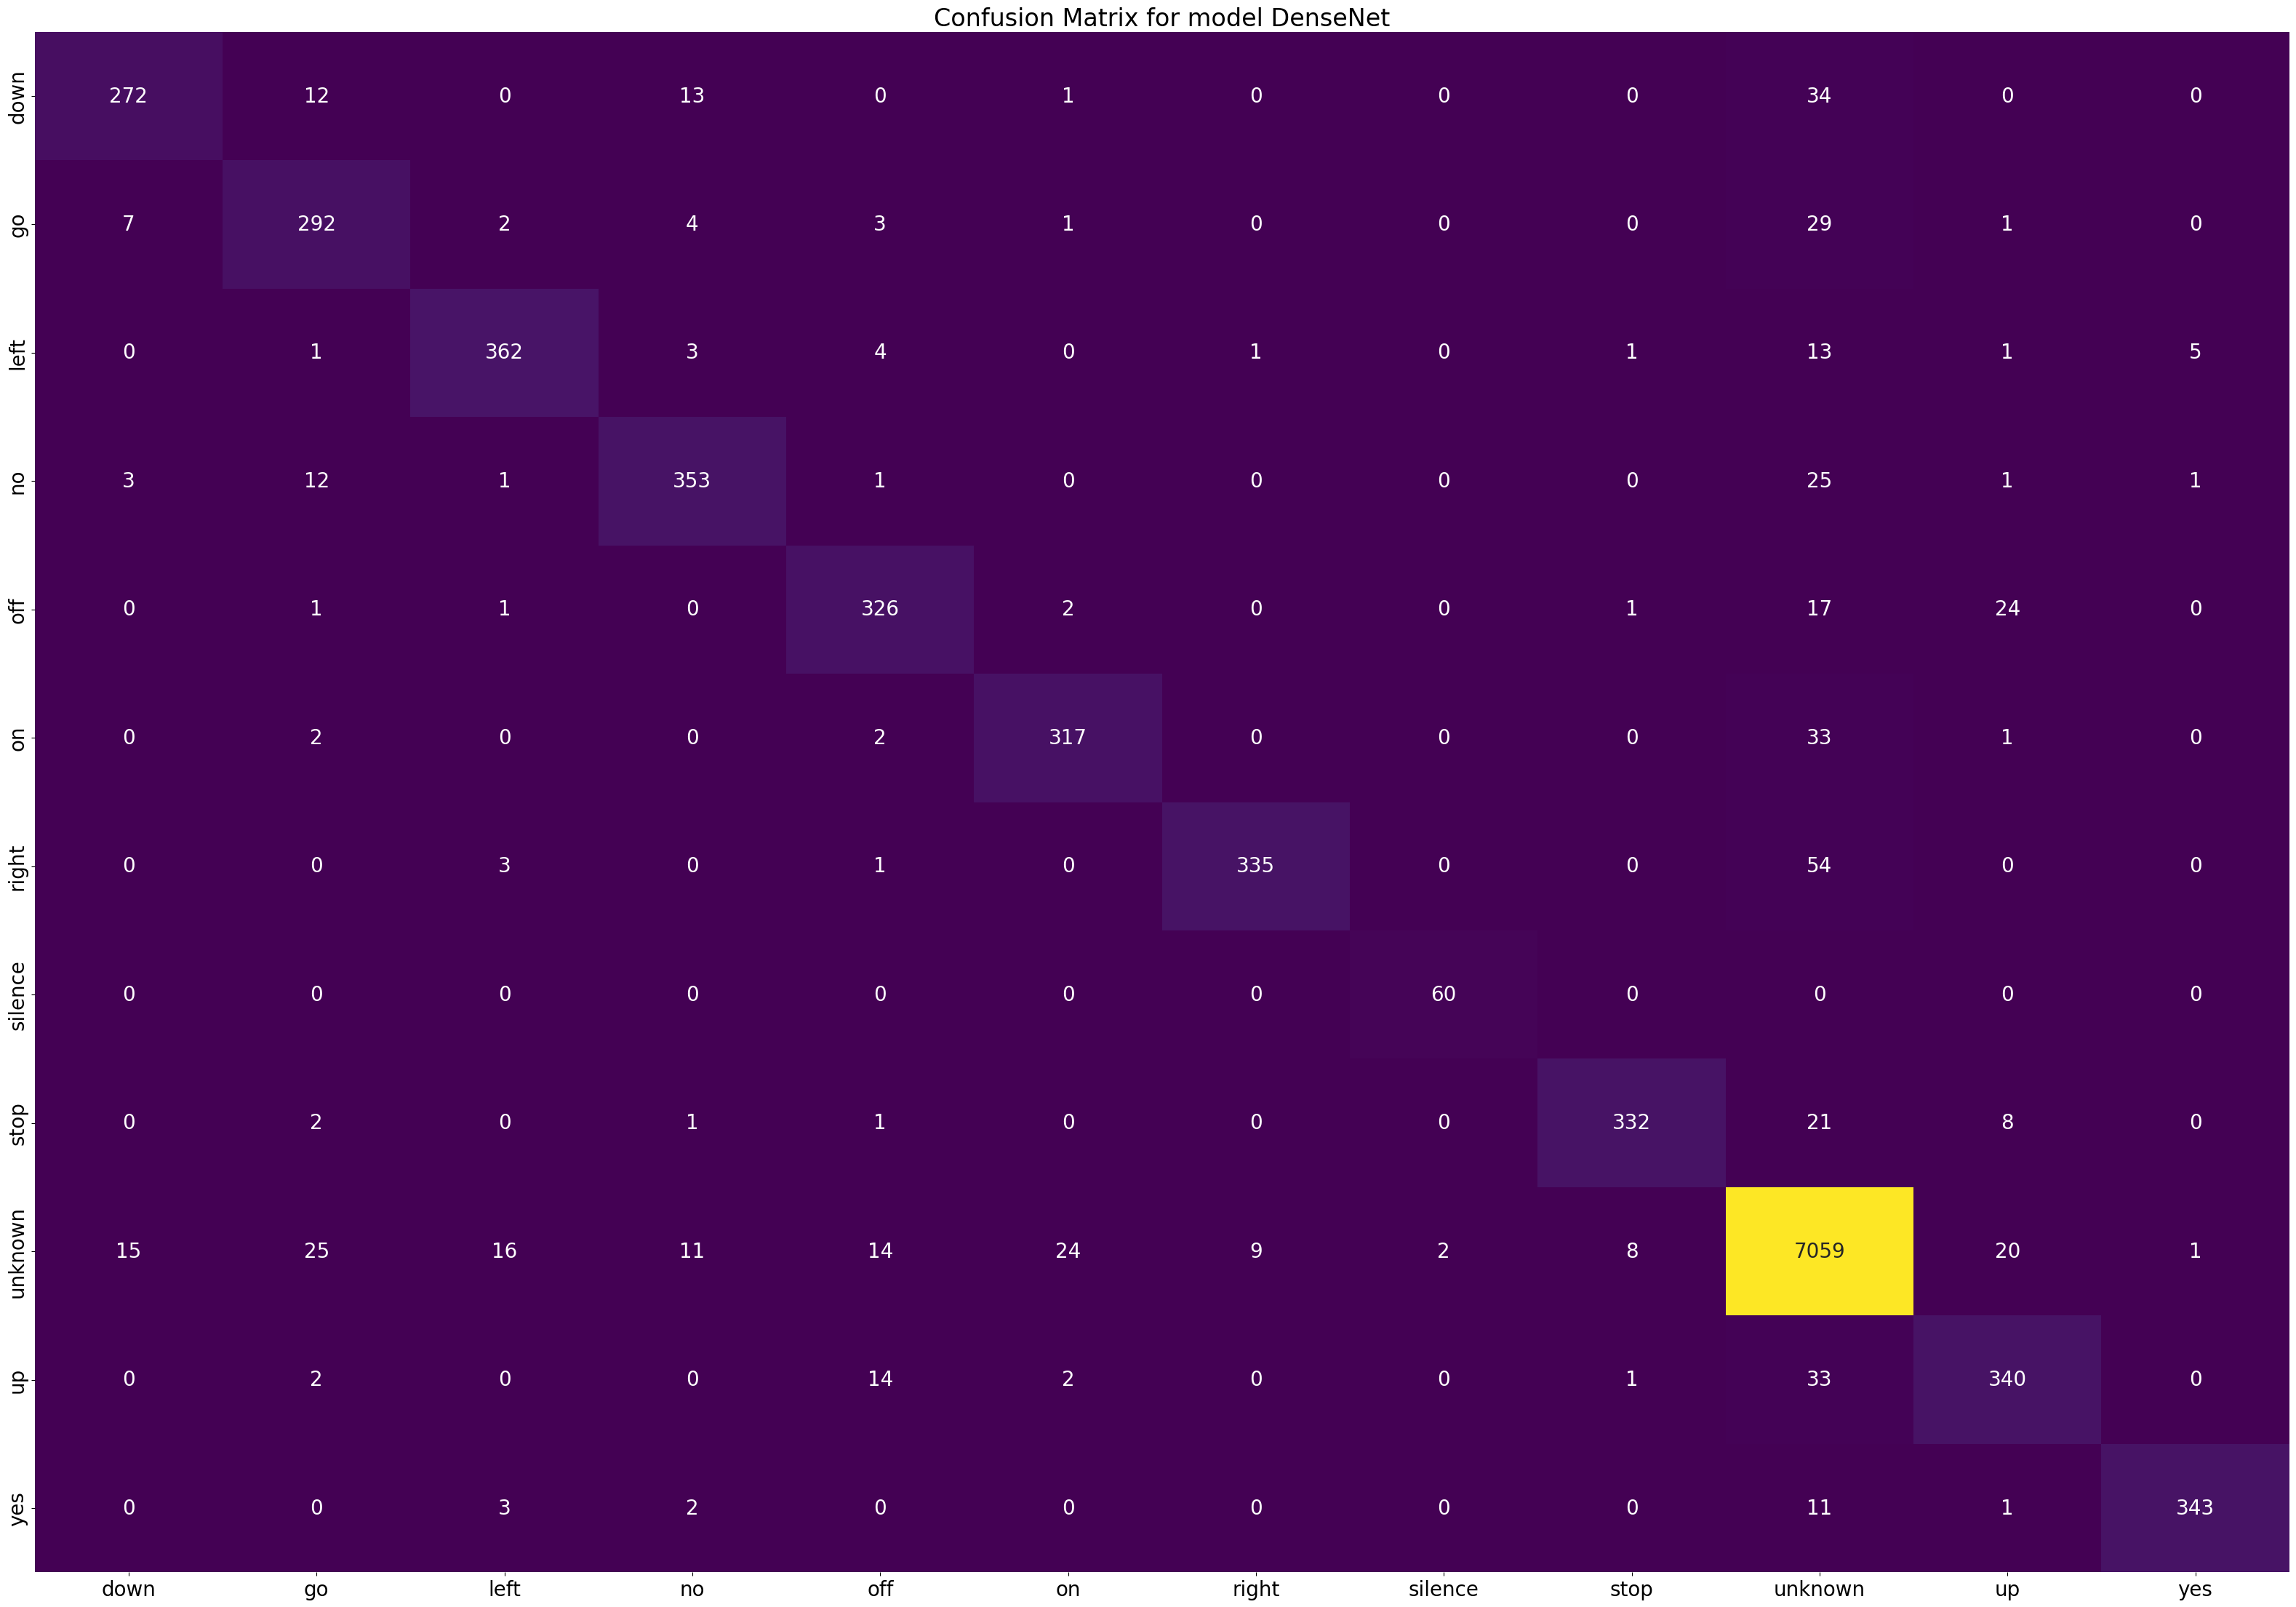

Most common mistakes:
[('right -> unknown: 54', np.int64(54)), ('down -> unknown: 34', np.int64(34)), ('on -> unknown: 33', np.int64(33)), ('up -> unknown: 33', np.int64(33)), ('go -> unknown: 29', np.int64(29))]
Model: Transformer with Augmentation
Accuracy: 0.919799268245697
Macro Average Precision: 0.8759849667549133
Macro Average Recall: 0.8545864224433899
Macro Average F1: 0.8636833429336548
No Average Precision: MulticlassPrecision()
No Average Recall: MulticlassRecall()
No Average F1: MulticlassF1Score()


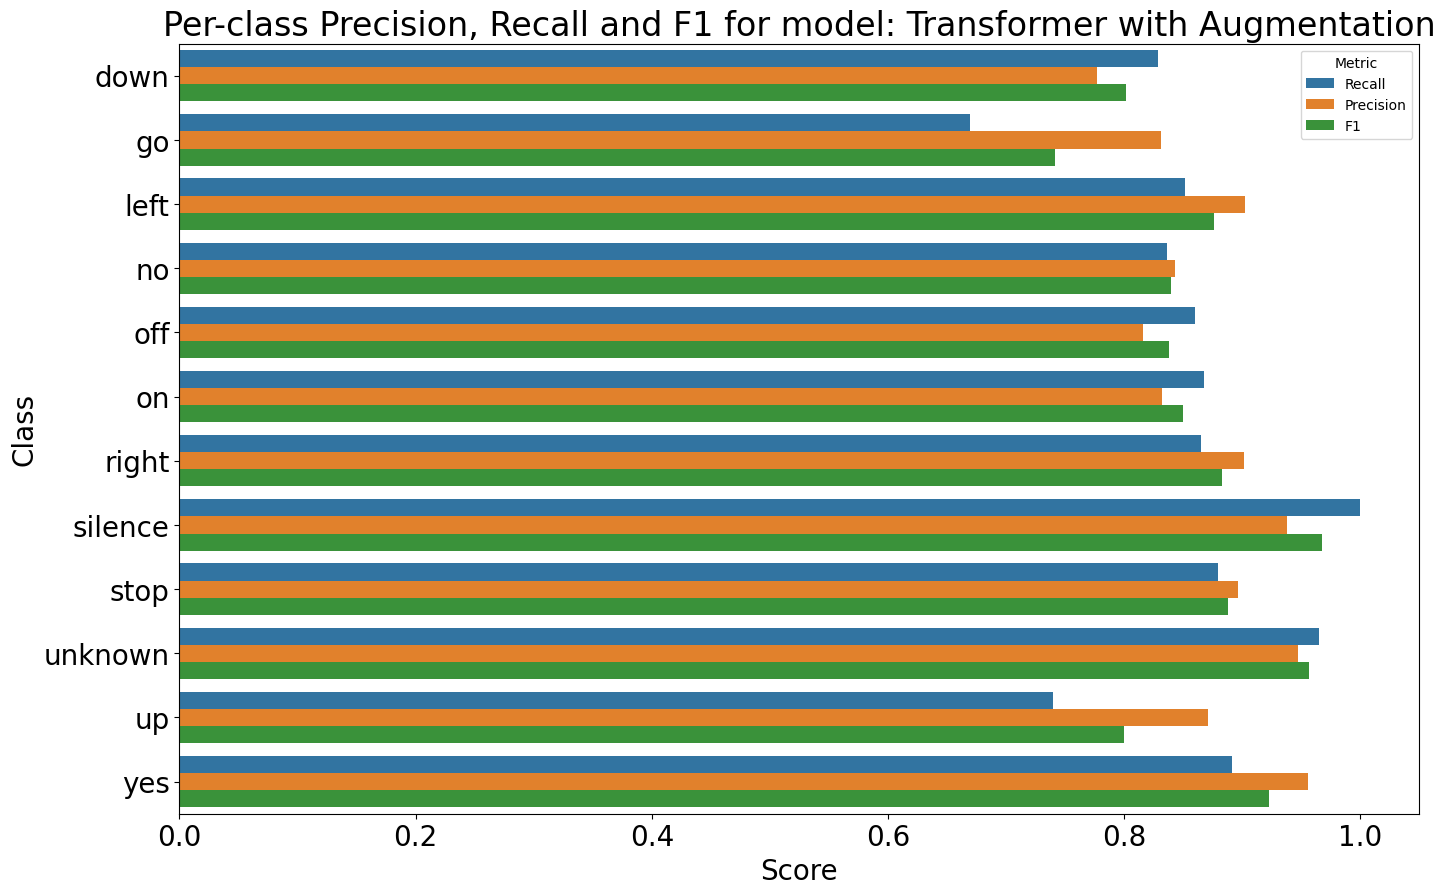

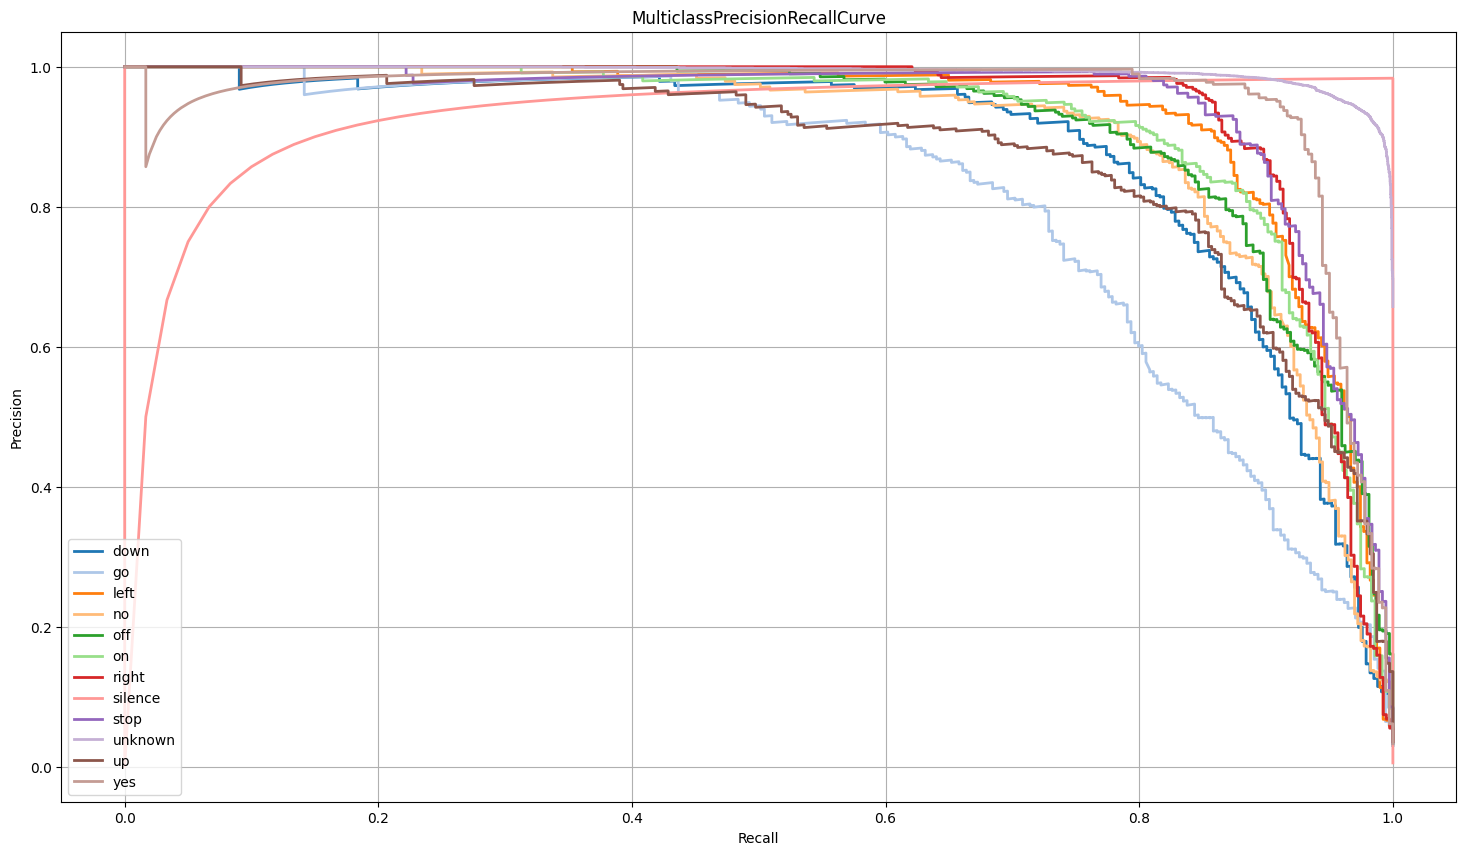

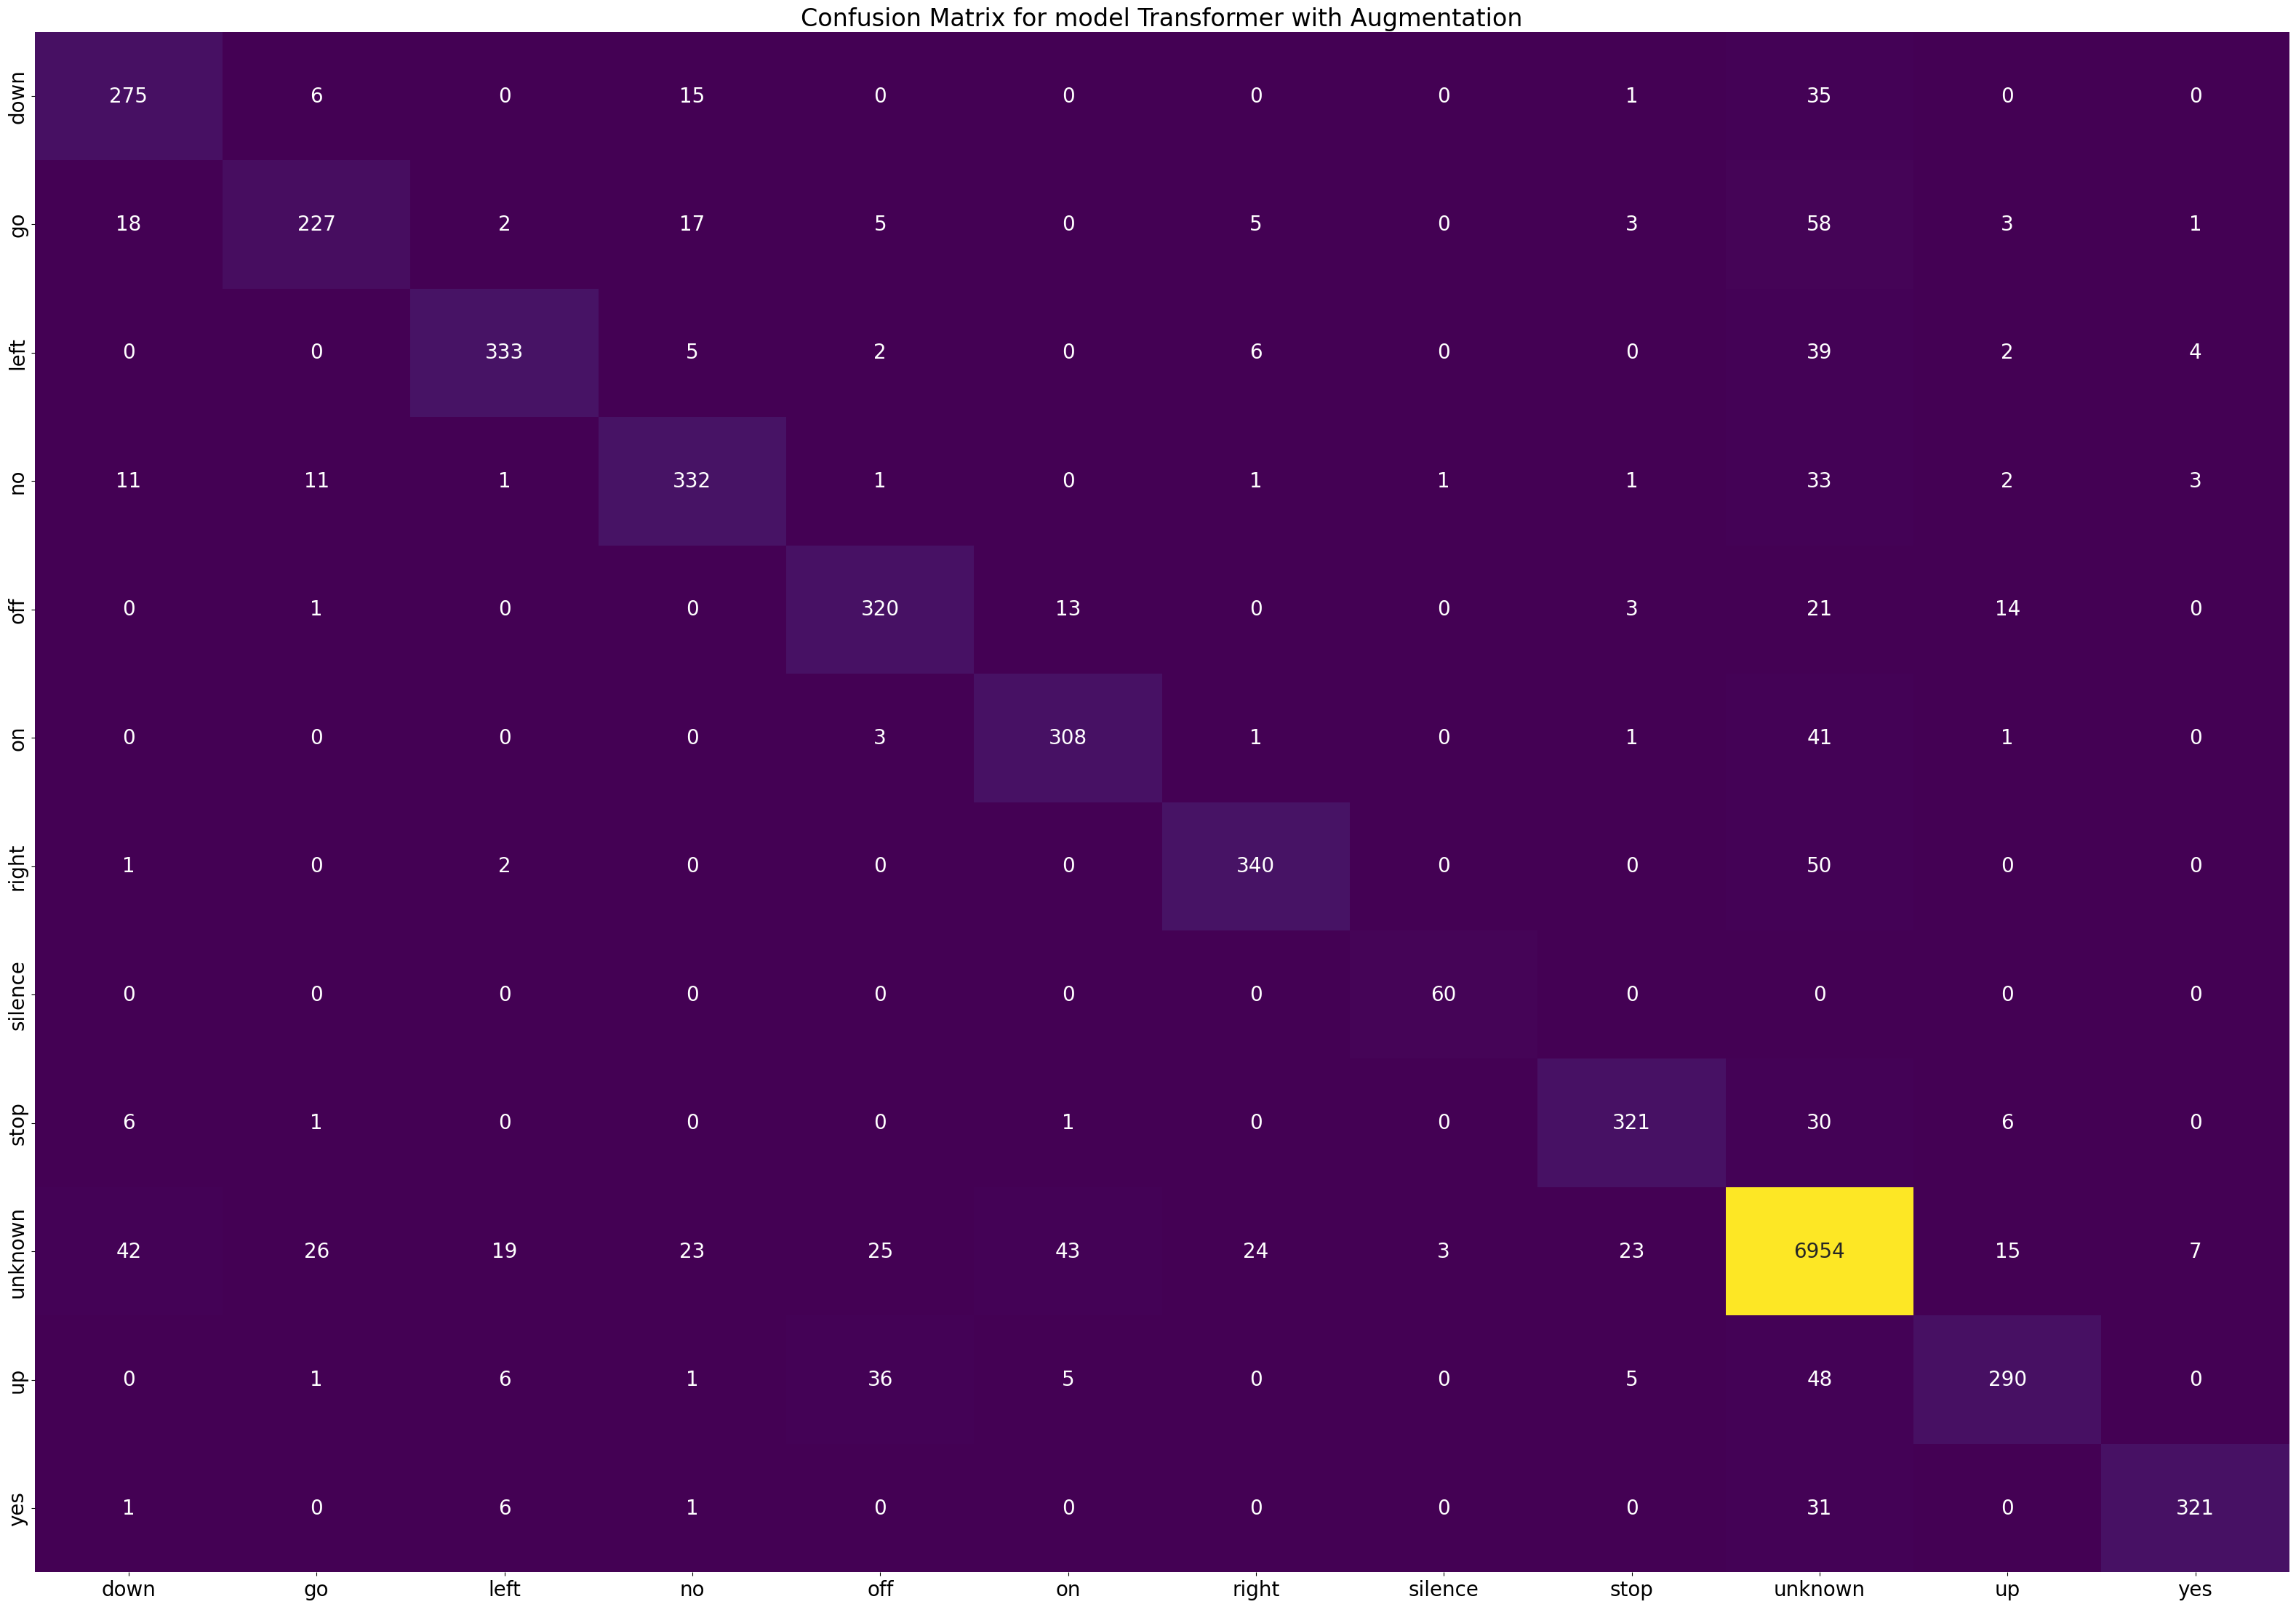

Most common mistakes:
[('go -> unknown: 58', np.int64(58)), ('right -> unknown: 50', np.int64(50)), ('up -> unknown: 48', np.int64(48)), ('unknown -> on: 43', np.int64(43)), ('unknown -> down: 42', np.int64(42))]


In [5]:
show_evaluation(dense_net_metrics, "DenseNet")
# show_evaluation(transformer_metrics, "Transformer")
# show_evaluation(transformer_weight_loss_metrics, "Transformer with Weighted Loss")
# show_evaluation(transformer_undersampling_metrics, "Transformer with Undersampling")
show_evaluation(transformer_augmentation_metrics, "Transformer with Augmentation")